在本教程中，我们将使用先前教程中介绍的TensorFlow原语来进行一些简单的机器学习。

TensorFlow还包括一个更高级别的神经网络API（tf.keras），它提供了有用的抽象来减少样板。我们强烈建议那些使用神经网络的人使用更高级别的API。但是，在这个简短的教程中，我们从第一原理开始介绍神经网络训练，以建立坚实的基础。

#### 建立

In [1]:
from __future__ import absolute_import,division,print_function,unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

#### 变量
TensorFlow中的张量是不可变的无状态对象。然而，机器学习模型需要具有变化的状态：随着模型训练，计算预测的相同代码应该随着时间的推移而表现不同（希望具有较低的损失！）。要表示需要在计算过程中进行更改的状态，您可以选择依赖Python是一种有状态编程语言的事实：

In [2]:
#Using python state
x = tf.zeros([10,10])
x +=2 # Tthis is equivalent to x = x + 2 ,which dose not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


但是，TensorFlow内置了有状态操作，这些操作通常比您所在州的低级Python表示更令人愉快。例如，为了表示模型​​中的权重，使用TensorFlow变量通常是方便有效的。

变量是一个存储值的对象，当在TensorFlow计算中使用时，它将隐式地从该存储值中读取。有些操作（`tf.assign_sub`，`tf.scatter_update`等）操纵存储在TensorFlow变量中的值。

In [3]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

#Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

#Use 'v' in a Tensorflow operation like tf.square() adn reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

计算梯度时会自动跟踪使用变量的计算。对于表示嵌入的变量，TensorFlow默认会进行稀疏更新，这样可以提高计算效率和内存效率。

使用变量也是一种快速让代码的读者知道这段状态是可变的方法。

#### 示例：拟合线性模型
现在，我们让我们有几个概念至今---` Tensor`，`GradientTape`，`Variable`---建立和培养一个简单的模型。这通常涉及几个步骤：

定义模型。
定义损失函数。
获取培训数据。
运行训练数据并使用“优化器”调整变量以适合数据。
在本教程中，我们将介绍一个简单线性模型的简单示例：`f(x) = x * W + b`它有两个变量 - W和b。此外，我们将合成数据，以便训练有素的模型具有`W = 3.0`和`b = 2.0`。

#### 定义模型
让我们定义一个简单的类来封装变量和计算。

In [4]:
class Model(object):
    def __init__(self):
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
        
    def __call__(self,x):
        return self.W * x + self.b
    
model = Model()
assert model(3.0).numpy() == 15.0

Instructions for updating:
Colocations handled automatically by placer.


#### 定义损失函数
损失函数测量给定输入的模型输出与期望输出的匹配程度。让我们使用标准的L2损失。

In [5]:
def loss(predicted_y,desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

#### 获取培训数据
让我们用一些噪音合成训练数据。

In [6]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs = tf.random_normal(shape=[NUM_EXAMPLES])
noise = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs *TRUE_W + TRUE_b + noise


在我们训练模型之前，让我们可以看到模型现在所处的位置。我们将用红色绘制模型的预测，用蓝色绘制训练数据。

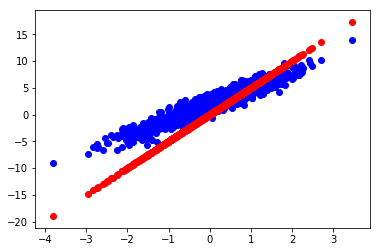

In [8]:
import matplotlib.pyplot as plt

plt.scatter(inputs,outputs,c='b')
plt.scatter(inputs,model(inputs),c='r')
plt.show()



In [9]:
print('Current loss:')
print(loss(model(inputs),outputs).numpy())

Current loss:
8.740504


#### 定义训练循环
我们现在拥有我们的网络和培训数据。让我们训练它，即使用训练数据来更新模型的变量（W和b），以便使用梯度下降来减少损失。在`tf.train.Optimizer`实现中捕获了许多梯度下降方案的变体。我们强烈建议使用这些实现，但本着从第一原则构建的精神，在这个特定的例子中，我们将自己实现基本的数学。

In [10]:
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
        
    dW,db = t.gradient(current_loss,[model.W,model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

最后，让我们通过反复训练数据运行，看看`W`和`b`发展。

Epoch  0: W=5.00 b=0.00, loss=8.74050
Epoch  1: W=4.61 b=0.40, loss=5.93922
Epoch  2: W=4.30 b=0.72, loss=4.14407
Epoch  3: W=4.04 b=0.97, loss=2.99368
Epoch  4: W=3.84 b=1.17, loss=2.25645
Epoch  5: W=3.68 b=1.34, loss=1.78399
Epoch  6: W=3.55 b=1.47, loss=1.48121
Epoch  7: W=3.45 b=1.57, loss=1.28716
Epoch  8: W=3.36 b=1.65, loss=1.16279
Epoch  9: W=3.30 b=1.72, loss=1.08309
Epoch 10: W=3.24 b=1.77, loss=1.03200
Epoch 11: W=3.20 b=1.81, loss=0.99926
Epoch 12: W=3.17 b=1.85, loss=0.97827
Epoch 13: W=3.14 b=1.87, loss=0.96482
Epoch 14: W=3.12 b=1.89, loss=0.95620
Epoch 15: W=3.10 b=1.91, loss=0.95067
Epoch 16: W=3.08 b=1.93, loss=0.94713
Epoch 17: W=3.07 b=1.94, loss=0.94486
Epoch 18: W=3.06 b=1.95, loss=0.94341
Epoch 19: W=3.06 b=1.95, loss=0.94247
Epoch 20: W=3.05 b=1.96, loss=0.94188
Epoch 21: W=3.04 b=1.96, loss=0.94149
Epoch 22: W=3.04 b=1.97, loss=0.94125
Epoch 23: W=3.04 b=1.97, loss=0.94109
Epoch 24: W=3.03 b=1.97, loss=0.94099
Epoch 25: W=3.03 b=1.97, loss=0.94092
Epoch 26: W=

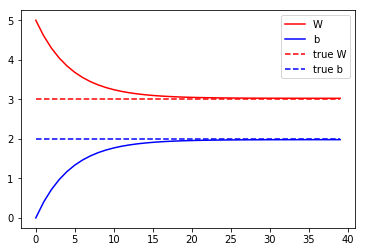

In [19]:
model = Model()

Ws,bs = [],[]
epochs = range(40)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs),outputs)
    
    train(model,inputs,outputs,learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
         (epoch,Ws[-1],bs[-1],current_loss))
    
    
plt.plot(epochs,Ws,'r',
        epochs,bs,'b')
plt.plot([TRUE_W]* len(epochs),'r--',
        [TRUE_b]*len(epochs),'b--')
plt.legend(['W','b','true W','true b'])
plt.show()